<a href="https://colab.research.google.com/github/kamo1010/injury-big-data/blob/main/Random_forest_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 빅데이터 분석 코드


본 연구는 의료 진료를 위한 후송 데이터를 연구하려고자 합니다.
Random forest 알골즘을 바탕으로 환자의 생존과 사망을 예측하기 위해 후송 데이터를 활용해서 원인들의 중요성을 측정하기로 합니다.

## 데이터 후처리

csv 파일을 읽어서 데이터를 뽑기로 합니다.
Pandas framework을 써서 파일에 든 데이터를 Dataframe 현태로 불러옵니다.
우선 그러기 전에 필요한 코드 라이브러리를 불러옵니다.

In [36]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas.tseries.offsets import Minute
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.model_selection import RandomizedSearchCV, train_test_split

import warnings
warnings.filterwarnings('ignore')

Pandas를 써봅니다.

데이터를 불러와서 내용부터 확인해봅시다.

In [ ]:
bank_data = pd.read_csv("sample_data/labels.csv", sep=";")
bank_data.head(5)

,연번,년도,월,일,날,주야간,기상조건,도시,지역,사무실,...,증상,환자유형,접수시간/이륙시간,환자 인수지역,도착시간/이륙시간,환자 후송지,후송지 도착 시간,복귀 이륙/복귀도착,출동~병원,후송결과
0,1,2021,7,27,목,주,go,대전,유성,문지로,...,두통,외상,1333/1454,A,1500/1503,대전병원,1537,1613/1720,133분,사망
1,2,2021,7,26,수,주,go,계룡,엄사,문지로,...,두통,외상,1333/1344,A,1450/1503,대전병원,1537,1613/1720,133분,사망
2,3,2021,7,25,화,주,go,인재,내일,문지로,...,두통,외상,1333/1344,A,1450/1503,대전병원,1537,1613/1720,133분,사망
3,4,2021,7,25,화,주,go,인재,내일,문지로,...,두통,외상,1333/1344,A,1450/1503,대전병원,1537,1613/1720,133분,사망
4,5,2021,7,21,금,주,go,계룡,엄사,문지로,...,두통,외상,1333/1344,A,1450/1503,대전병원,1537,1613/1720,133분,사망


칼럼 21개 중 후처리로 몇가지 새로운 데이터로 전환할 수 있습니다.

0. 인코딩 문제가 없도록 각 행 명을 영문으로 바꿉니다: **``date``**, **``season``**, **``day or night``**, **``city``**, **``district``**, **``location``**, **``position``**, **``wound``**, **``patient type``**, **``patient acceptance area``**, **``patient transfer area``**,
1. **``연번``**은 불필요한 ID 를 불러오며, 제거할 수 있겠습니다.
2. **``년도``**, **``월``**, **``일``** 행들을 **``날짜``** 데이터로 바꿀 수 있습니다. 추가로 월에거 **``계절``** 정보까지 수집할 수 있습니다.
3. **``주야간``** (**``day or night``**) 데이터는 유지시킬 수 있겠습니다.
4. **``도시``**, **``지역``**, **``사무실``**, **``환자 인수지역``**, 그리고 **``환자 후송지``**는 지역과 후송 정보를 가지고 있으며 그대로 유지할 필요가 있다.
5. **``급``**, **``증상``**, **``환자유형``**은 환자의 부상 데이터를 묘사하므로 데이터를 유지해야 하겠습니다.
6. **``접수시간/이륙시간``**, **``도착시간/이륙시간	``**, **``복귀 이륙/복귀도착	``**과 **``후송지 도착 시간``**은 시간대를 알려주는 데이터들이며, 시간 데이터를 분리할 필요가 있습니다.
7. **``출동~병원``** 요소는 **``이륙시간``**과 **``후송지 도착 시간``**사이 흐른 기간을 묘사하며, 따로 계산이 가능합니다. 이 기간보다 **``접수기간``** 부터 **``후송지 도착시간``** 사이 기간이 환자 대기 기간에 더 가까우며 이 기간 계산을 **``대기기간``** 으로 택하기로 합니다. 또는 환자의 실제 후송 기간을 계산하여 **``후송 기간``** 을 계산하기로 합니다.
8. **``후송 결과``**를 예측하는 목적이므로, 이를 **``y``** label을 줍니다.


In [ ]:
def split_time(x):
  times = x.split('/')
  times.append(times[1][:2])
  times.append(times[1][2:])
  times[1]=times[0][2:]
  times[0]=times[0][:2]
  return pd.Series(times)

bank_data = pd.read_csv("sample_data/labels.csv", sep=";")
bank_data.head(5)

#step 0
bank_data.rename(columns = {'년도':'year', '월':'month', '일':'day'}, inplace = True)
bank_data.rename(columns = {'날':'day of week', '주야간':'day night', '기상조건':'weather'}, inplace = True)
bank_data.rename(columns = {'도시':'city', '지역':'region', '사무실':'location'}, inplace = True)
bank_data.rename(columns = {'급':'position', '증상':'wound', '환자유형':'patient type'}, inplace = True)
bank_data.rename(columns = {'환자 인수지역':'patient acceptance area', '환자 후송지':'patient transfer area'}, inplace = True)
bank_data.rename(columns = {'후송지 도착 시간':'time of arrival at transfer area'}, inplace = True)

# step 1
bank_data = bank_data.drop(columns=["연번"])
bank_data.insert(0, "date", pd.to_datetime(bank_data[["year", "month", "day"]]))

#step 2
bank_data.insert(1, "season", bank_data['month'].map({1:3, 2:3, 3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:2, 10:2, 11:2, 12:3}))
bank_data['day of week'] = bank_data['day of week'].map({'월':0, '화':1, '수':2, '목':3, '금':4, '토':5, '일':6})
bank_data['day night'] = bank_data['day night'].map({'주':0, '야':1})
bank_data['weather'] = bank_data['weather'].map({'no-go':0, 'go':1})

#step 6
bank_data[["registration hour", "registration minute", "takeoff hour", "takeoff minute"]]= bank_data.apply(lambda x: split_time(x['접수시간/이륙시간']), axis=1)
bank_data.insert(11, "registration time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["registration hour"], 'minute': bank_data["registration minute"]})).astype(int))
bank_data.insert(12, "hospital takeoff time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["takeoff hour"], 'minute': bank_data["takeoff minute"]})).astype(int))
bank_data = bank_data.drop(columns=['registration hour']).drop(columns=['registration minute']).drop(columns=['접수시간/이륙시간'])

bank_data[["arrival hour", "arrival minute", "takeoff hour", "takeoff minute"]]= bank_data.apply(lambda x: split_time(x['도착시간/이륙시간']), axis=1)
bank_data.insert(13, "location arrival time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["arrival hour"], 'minute': bank_data["arrival minute"]})).astype(int))
bank_data.insert(14, "patient takeoff time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["takeoff hour"], 'minute': bank_data["takeoff minute"]})).astype(int))
bank_data = bank_data.drop(columns=['takeoff hour']).drop(columns=['takeoff minute']).drop(columns=['도착시간/이륙시간'])

bank_data[["departure hour", "departure minute", "arrival hour", "arrival minute"]]= bank_data.apply(lambda x: split_time(x['복귀 이륙/복귀도착']), axis=1)
bank_data.insert(15, "recovery departure time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["departure hour"], 'minute': bank_data["departure minute"]})).astype(int))
bank_data.insert(16, "recovery arrival time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["arrival hour"], 'minute': bank_data["arrival minute"]})).astype(int))
bank_data = bank_data.drop(columns=['departure hour']).drop(columns=['departure minute']).drop(columns=['arrival hour']).drop(columns=['arrival minute']).drop(columns=['복귀 이륙/복귀도착'])

bank_data[["arrival hour", "arrival minute"]]= pd.Series([bank_data['time of arrival at transfer area']//100, bank_data['time of arrival at transfer area']%100])
bank_data["time of arrival at transfer area"] = pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["arrival hour"], 'minute': bank_data["arrival minute"]})).astype(int)
bank_data = bank_data.drop(columns=['arrival hour']).drop(columns=['arrival minute'])
bank_data = bank_data.drop(columns=['year', 'month', 'day', 'date'])

#step 7
bank_data.rename(columns = {'출동~병원':'waiting delay'}, inplace = True)
bank_data["waiting delay"]= (pd.to_datetime(bank_data["time of arrival at transfer area"])-pd.to_datetime(bank_data["registration time"])).astype(int)
bank_data.insert(20, "transfer delay", (pd.to_datetime(bank_data["time of arrival at transfer area"])-pd.to_datetime(bank_data["patient takeoff time"])).astype(int))

#step 8
bank_data.rename(columns = {'후송결과': 'y'}, inplace = True)
bank_data['y'] = bank_data['y'].map({'사망':0, '생존':1})

#step 9
levels={'a':1, 'b':2, 'c':3, 'd':4, 'e':5, 'f':6, 'g':7, 'h':8, 'i':9, 'j':10, 'k':11, 'l':12, 'm':13, 'n':14, 'o':15, 'p':16, 'q':17, 'r':18, 's':19, 't':20}
bank_data["position"] = bank_data["position"].map(levels)
columns={"city", "region", "location", "wound", "patient type", "patient acceptance area", "patient transfer area"}
for col in columns:
  tmp = {}
  idx = 0
  for elt in bank_data[col]:
    if (elt not in tmp):
      tmp[elt] = idx
      idx+=1
  bank_data[col] = bank_data[col].map(tmp)

bank_data.head()

,season,day of week,day night,weather,city,region,location,registration time,hospital takeoff time,location arrival time,...,recovery arrival time,position,wound,patient type,patient acceptance area,patient transfer area,time of arrival at transfer area,waiting delay,transfer delay,y
0,1,3,0,1,0,0,0,1627392780000000000,1627397640000000000,1627398000000000000,...,1627406400000000000,4,0,0,0,0,1627400220000000000,7440000000000,2040000000000,0
1,1,2,0,1,1,1,0,1627306380000000000,1627307040000000000,1627311000000000000,...,1627320000000000000,4,0,0,0,0,1627313820000000000,7440000000000,2040000000000,0
2,1,1,0,1,2,2,0,1627219980000000000,1627220640000000000,1627224600000000000,...,1627233600000000000,1,0,0,0,0,1627227420000000000,7440000000000,2040000000000,0
3,1,1,0,1,2,2,0,1627219980000000000,1627220640000000000,1627224600000000000,...,1627233600000000000,1,0,0,0,0,1627227420000000000,7440000000000,2040000000000,0
4,1,4,0,1,1,1,0,1626874380000000000,1626875040000000000,1626879000000000000,...,1626888000000000000,3,0,0,0,0,1626881820000000000,7440000000000,2040000000000,0


Input 데이터 X 와 output 데이터 y 를 분류해서 환자의 사망 사항을 결과물로, 나머지 요소들은 사망과 생존에 가능한 원인들로 인식했습니다.
추가로, 전체 데이터를 학습 데이터셋과 테스트 데이터셋으로 구분합니다.
충분한 학습을 위해 학습과 테스트 데이터 량 비율은 임의적으로 7 대 3의 비율로 맞퉜습니다.

In [ ]:
# Split the data into features (X) and target (y)
X = bank_data.drop('y', axis=1)
y = bank_data['y']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Sklearn의 Random Forest Classifier 활용

학습 데이터셋을 Random Forest 모델에 적용할 수 있습니다.

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

모델을 학습 데이터를 기반으로 훈련을 다 시킨 후, 데스트 데이터셋으로 발견한 모델의 신뢰성을 테스트 합니다.
먼저 3 가지의 요소를 연구합니다:
* Accuracy(정확도): 모든 예측 중 맞춘 예측의 비율
* Precision(정밀도): 예측된 y 값 별로 예측 중 맞춘 y 값의 비율
* Recall(재현율):  실제 y 값 별로 맞춘 y 예측 값의 비율

데이터 학습의 도표를 봅니다(추후에는 이 도표를 혼동 행렬(또는 Confusion Matrix)라고 불립니다):

| 실험 결과\실제 정답 | 1  | 0  |
|-------------|----|----|
| 1           | 실양(true positive, tp) | 가양(false positive, fp) |
| 0           | 가음(false negative, fn) | 실음(true negative, tn) |

학습 모델의 신뢰성을 계산할 때 3 가지의 요소를 다음과 같이 해석할 수 있습니다:
* Accuracy(정확도): $$ Accuracy = {{tp + tn} \over {tp + fp + tn + fn}} $$
* Precision(정밀도): $$ Precision = {tp \over {tp + fp}} $$
* Recall(재현율):  $$ Recall = {tp \over {tp + fn}} $$

In [ ]:
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall:", recall)

Accuracy:  0.8333333333333334
Precision:  0.5
Recall: 0.5


이 결과를 주게 된 의사 결정 나무(Decision Trees) 몇가지를 예시로 볼 수 있겠습니다(아래 코드는 11개만 출였지만, 연산자원만 충분하면 전 숲을 다 볼 수 있겠습니다만, 현 노트북으로써는 불가능합니다).

Forest population:  100


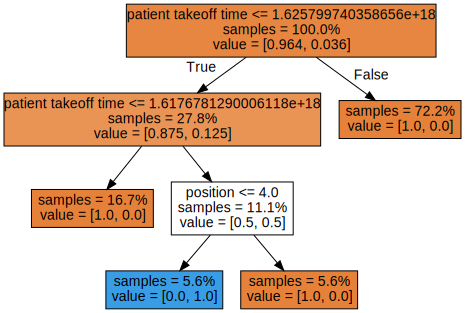

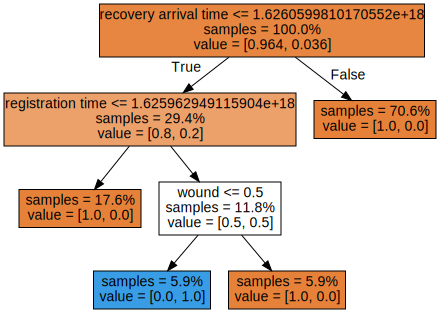

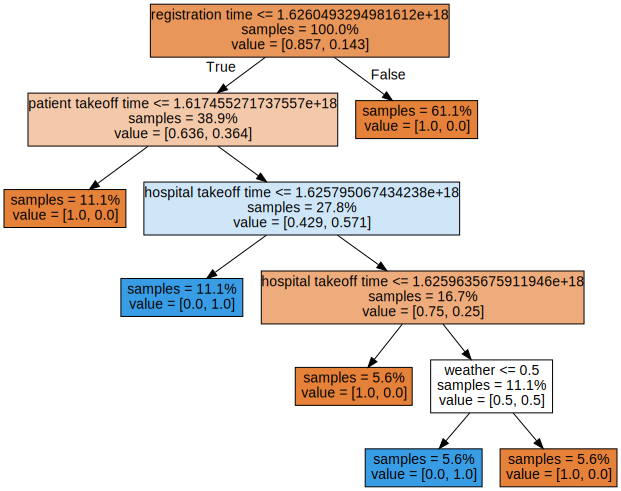

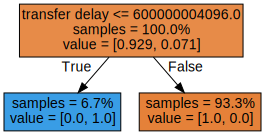

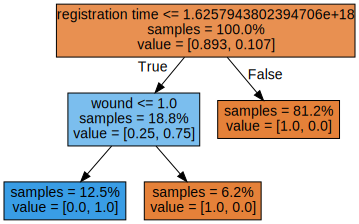

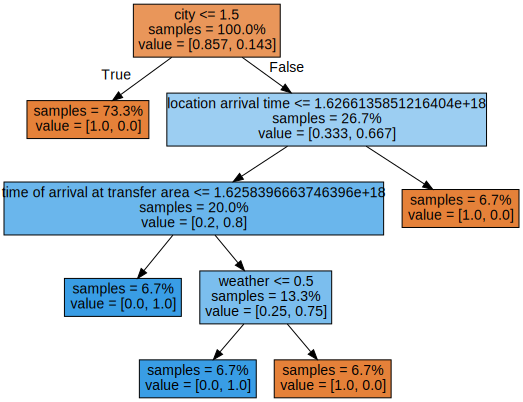

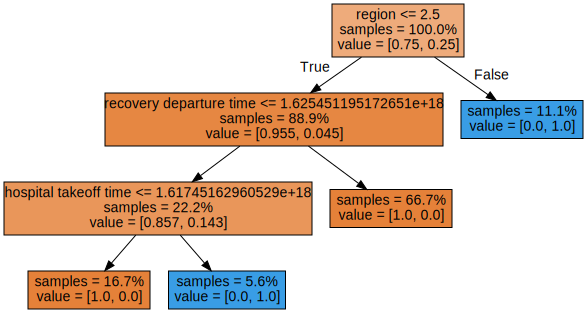

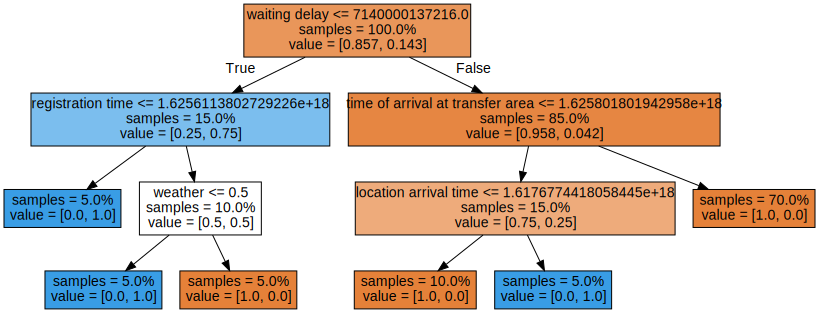

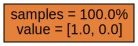

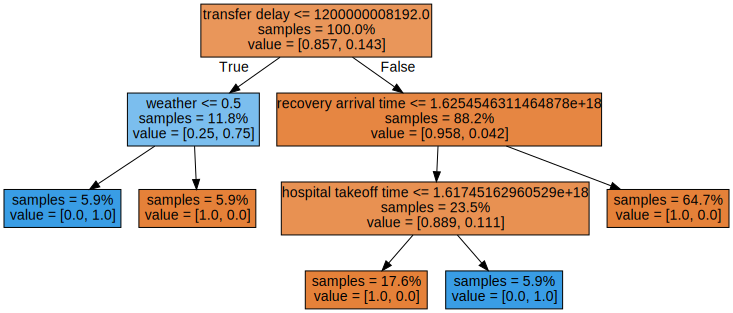

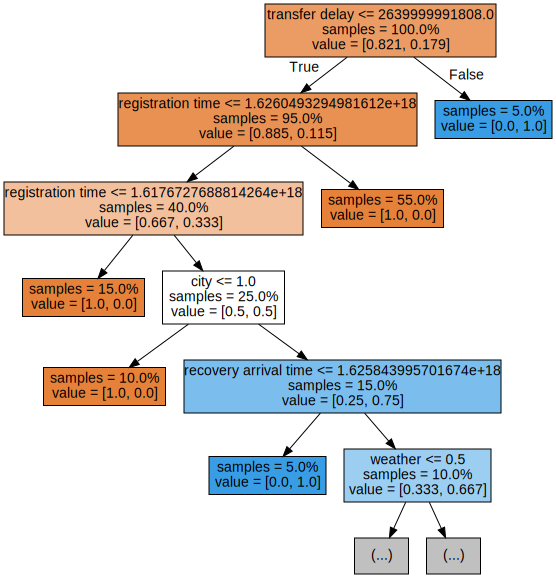

In [ ]:
print("Forest population: ", len(rf.estimators_))

# Export all the decision trees from the forest
for tree in rf.estimators_[:11]:
  dot_data = export_graphviz(tree, feature_names=X_train.columns, filled=True, max_depth=5, impurity=False, proportion=True)
  graph = graphviz.Source(dot_data)
  display(graph)

Random Forest Classifier의 사용법을 익혔으니, 최적한 Random Forest Classifier를 찾아보도록 했습니다.
Random Forest의 성능을 결정적으로 여기는 변수는 바로 의사 결정 나무(Decision Tree)의 최고 깊이(max depth, 즉 몇 층의 가지까지 내려갈지)와 추정개수(number of estimators, 즉 숲을 채우는 나무의 개수) 입니다.

이들을 구하기 위해 Random Forest Classifier 모델에 Randomized Search Cross Vaalidation 검색을 실행합니다.
Search 인스턴스를 생성하고 실행되는대로 학습데이터를 돌려서 최적한 모델 변수를 알아서 맞춰갑니다.

In [17]:
n_estimators = randint(50, 500)
max_depth= randint(1, 20)

param_dist = {'n_estimators': n_estimators, 'max_depth': max_depth}

# Create a ranom forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, cv=15)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=15.
  warnings.warn(


RandomizedSearchCV(cv=15, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x786a5153bb80>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x786a5153aef0>})

해서 나무개수와 최고 깊이를 구했습니다.

In [18]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best parameters
print('Best hyperparameters: ', rand_search.best_params_)

Best hyperparameters:  {'max_depth': 2, 'n_estimators': 293}


최적한 Random Forest Classifier로 데스트 데이터를 다시 시도해봅시다. 테스트를 통해 다시 정확도, 정밀도와 재형율을 계산해봅니다.
추가로 예상과 현실 데이터의 정확도를 표현하는 혼돈행렬을 표시합니다.

Accuracy:  0.8333333333333334
Precision:  0.0
Recall: 0.0
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.00      0.00      0.00         2

    accuracy                           0.83        12
   macro avg       0.42      0.50      0.45        12
weighted avg       0.69      0.83      0.76        12



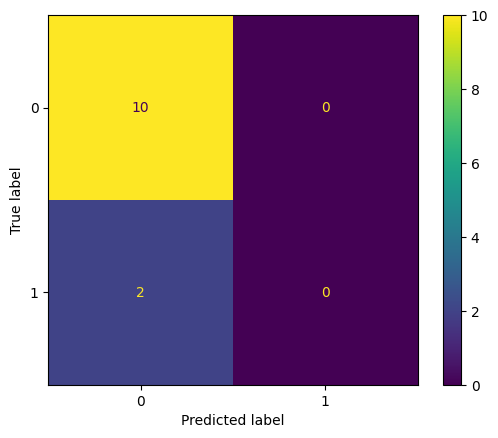

In [26]:
# Generate predictions wit the best model
rf_y_pred = best_rf.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, rf_y_pred))
print("Precision: ", precision_score(y_test, rf_y_pred))
print("Recall:", recall_score(y_test, rf_y_pred))


# Create the confusion matrix
rf_cm = confusion_matrix(y_test, rf_y_pred)
ConfusionMatrixDisplay(confusion_matrix=rf_cm).plot()

# View the classification report for test data and predictions
print(classification_report(y_test, rf_y_pred))

따라서 최적화된 모델을 기준으로 각각의 요소들이 결과 y의 값에 얼마나 큰 영향을 주는지 검색할 수 있습니다.

<Axes: >

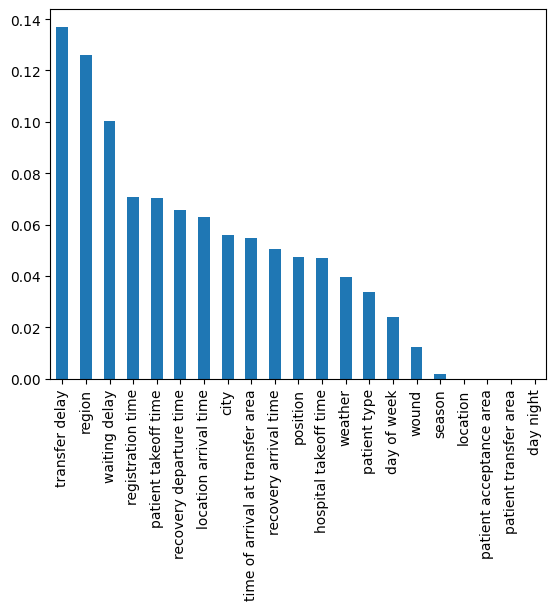

In [20]:
# Create a series containing feature importances from the model and their names from the training data
rf_feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
rf_feature_importances.plot.bar()

하지만 혼돈 행렬을 통해 보셨다시피, 현재 모델을 기준으로 예측 성능이 많이 부족합니다.
이의 가장 큰 이유가 데이터 부족도 있지만, 우선 데이터 비율은 한 y 값이 과하게 묘사 됐으며, 그에 비해 다른 한 값은 너무 적게 나타난다.
이 현상을 unbalanced data로 표현하며 소수와 다수의 비율이 너무 뚜렷한 게 문제입니다.

앞으로 이 편향된 데이터셋을 가지고 더 균형 잡혀 보이도록 학습하는 방법을 알아보겠습니다.

## Sklearn의 Balanced Random Forest Classifier

In [ ]:
from statistics import mean
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier

Imbalanced data를 학습하기 위해 imblearn 패키지를 활용했습니다.
위에 일반 Random Forest classifier와 같은 방식으로 최적된 모델을 생사하여 정확도, 정밀도와 재형율 및 혼돈핸렬을 나타냈습니다.

Accuracy:  0.75
Precision:  0.4
Recall: 1.0
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.40      1.00      0.57         2

    accuracy                           0.75        12
   macro avg       0.70      0.85      0.70        12
weighted avg       0.90      0.75      0.78        12



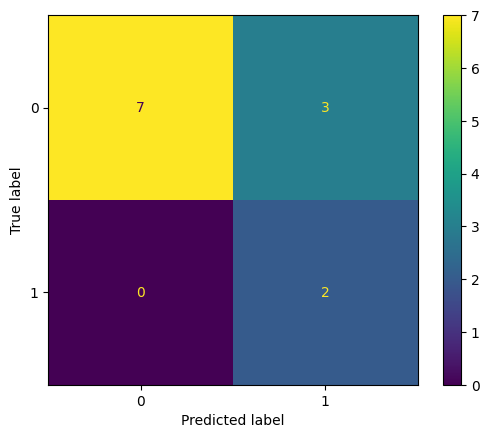

In [27]:
# Build BRF model
BRFC = BalancedRandomForestClassifier(n_estimators=150, random_state=2)

# Create Strtified K-Fold cross validation
cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('accuracy', 'precision', 'recall')

# Evaluate BRF model
scores = cross_validate(BRFC, X, y, scoring=scoring, cv=cv)

BRFC.fit(X_train, y_train)

# BRFC prediction result
brf_y_pred = BRFC.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, brf_y_pred))
print("Precision: ", precision_score(y_test, brf_y_pred))
print("Recall:", recall_score(y_test, brf_y_pred))


# Create the confusion matrix
brf_cm = confusion_matrix(y_test, brf_y_pred)
ConfusionMatrixDisplay(confusion_matrix=brf_cm).plot()

# View the classification report for test data and predictions
print(classification_report(y_test, brf_y_pred))

마지막으로, 데이터셋 사망요소들을 중요성의 역순서대로 정렬해뒀습니다.

<Axes: >

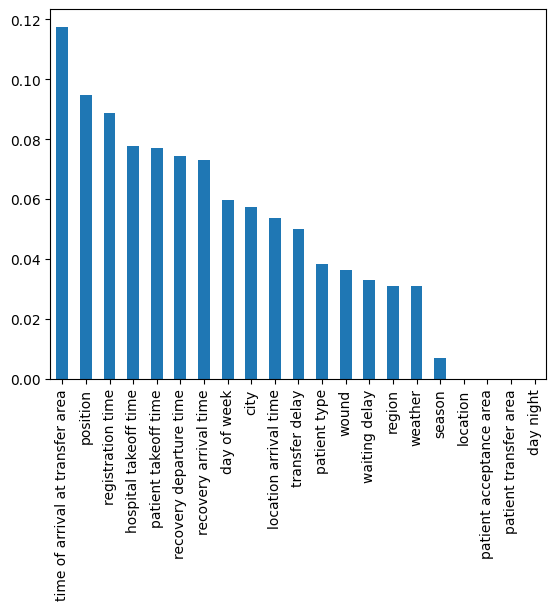

In [24]:
# Create a series containing feature importances from the model and their names from the training data
brf_feature_importances = pd.Series(BRFC.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
brf_feature_importances.plot.bar()

Balanced Random Forest Classifier 모델의 사용으로 인해 나온 결과물도 그다지 좋지는 않습니다.여기서 나타난 바로는 이미 적은 데이터량에서 다수의 classifier 결과값과 input 데이터를 방치하여 모델 학습에 포함하지 않았습니다.

결과적으로 기본 적은 데이터셋과 imbalanced dataset을 지닌 모델에서는 Random Forest 모델보다 언더샘플링 효과가 발생할 확률이 높아집니다.

데이터가 적은 경우 SMOTE(Synthetic Minority Oversampling TEchnique) 기법을 택해봅니다.
SMOTE의 방식은 다음과 같습니다:
1. 소수의 class를 탐색하여
2. 이의 가장 가까운(의미/요소, 또는 백락이 비슷한) 데이터를 인지합니다(이를 이웃, neighbor, 라고 부릅니다)
3. 이웃과 소수 class의 한 점과 사이 거리에 새로운 데이터를 제작합니다

Accuracy:  0.9166666666666666
Precision:  0.6666666666666666
Recall: 1.0
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.67      1.00      0.80         2

    accuracy                           0.92        12
   macro avg       0.83      0.95      0.87        12
weighted avg       0.94      0.92      0.92        12



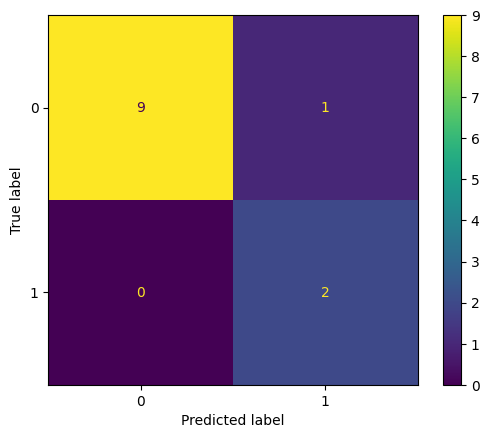

In [33]:
from imblearn.over_sampling import SMOTE

# Use SMOTE to oversample the minority clss
# SMOTE takes in consideration k_neighbors=5 by default. If the datast_sample requires it to, the model has to take fewer k_neighbors, just like we did here
# oversample = SMOTE(k_neighbors=3)
oversample = SMOTE(k_neighbors=3)
over_X, over_y = oversample.fit_resample(X, y)

over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.4, stratify=over_y)

# Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=0)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('accuracy', 'precision', 'recall')

# Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)


# Randomly split dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
smote_y_pred = SMOTE_SRF.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, smote_y_pred))
print("Precision: ", precision_score(y_test, smote_y_pred))
print("Recall:", recall_score(y_test, smote_y_pred))


# Create the confusion matrix
smote_cm = confusion_matrix(y_test, smote_y_pred)
ConfusionMatrixDisplay(confusion_matrix=smote_cm).plot()

# View the classification report for test data and predictions
print(classification_report(y_test, smote_y_pred))

<Axes: >

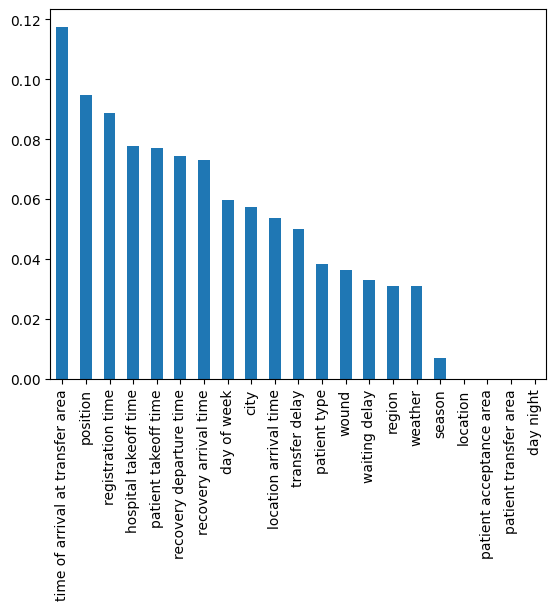

In [31]:
# Create a series containing feature importances from the model and their names from the training data
brf_feature_importances = pd.Series(BRFC.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
brf_feature_importances.plot.bar()

# 결론

끝마디로, 데이터의 구조와, 각 클래시파이어(classifier)별 결과값의 양에 달려서 더 적갑한 모델이 달라집니다.

* 일반 **Random Forest Classifier**의 경우 모델의 balance가 맞은 경우 정확한 결과를 가질 수 있지만, 결과 값 비율이 크게 편견이 있으면 성능이 떨어질 수 있습니다.

* **Balanced Random Forest Classifier**의 경우, 학습 데이터셋에서 다수의 결과 값들 중 일 부를 가리고 계산하기 때문에 데이터가 적은 경우 심한 underfitting 현상이 발생할 수 있습니다.

* **SMOTE** 기법을 사용하게 되며 학습 데이터셋을 기반으로  저수의 결과값 개수를 확장하기 위해 새로운 데이터를 가상적으로 생성합니다. 이런 경우, 굉장히 민감한 모델의 경우 overfitting이 발생할 수 있으므로 주의해야 합니다.

무론 classifier모델도 다양하지만, 현재 연구에서는 사망자와 생존자를 구분하고 예측하는 면도 중요했지만, 그 결과에 도달게 된 요소들의 중요성을 포함하기위해 Random Forest 기법을 활용하게 됐습니다. 앞으로 부상 후 환자 우송에 사망 예방 방안의 면에서 더 발전된 모델이 생기면 실해해보기를 바라겠습니다.

아래에는 각 보델의 신뢰성 테스트의 계산값을 총정리해봅니다.

RF Accuracy:  0.8333333333333334
RF Precision:  0.0
RF Recall: 0.0
RF F1 score: 0.0
BRF Accuracy:  0.75
BRF Precision:  0.4
BRF Recall: 1.0
RF F1 score: 0.5714285714285715
SMOTE Accuracy:  0.9166666666666666
SMOTE Precision:  0.6666666666666666
SMOTE Recall: 1.0
RF F1 score: 0.8


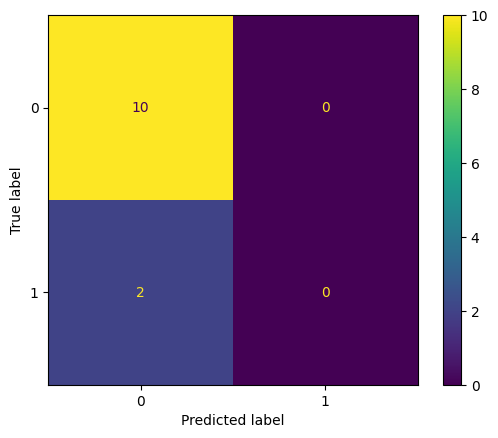

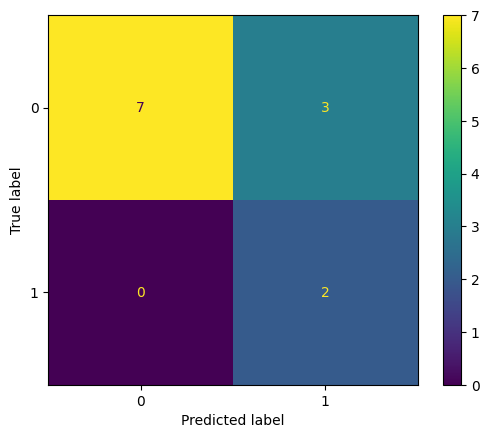

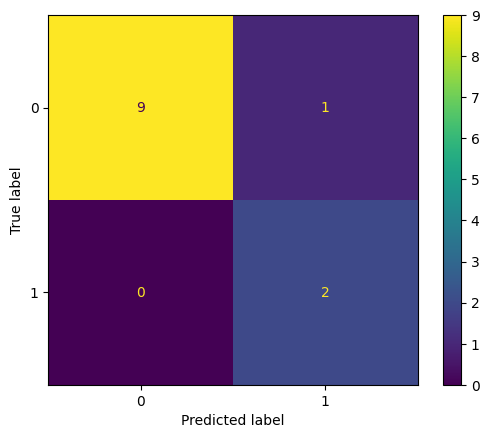

In [39]:
print("RF Accuracy: ", accuracy_score(y_test, rf_y_pred))
print("RF Precision: ", precision_score(y_test, rf_y_pred))
print("RF Recall:", recall_score(y_test, rf_y_pred))
print("RF F1 score:", f1_score(y_test, rf_y_pred))


# Create the confusion matrix
rf_cm = confusion_matrix(y_test, rf_y_pred)
ConfusionMatrixDisplay(confusion_matrix=rf_cm).plot()
print("=======================================")
print("=======================================")

print("BRF Accuracy: ", accuracy_score(y_test, brf_y_pred))
print("BRF Precision: ", precision_score(y_test, brf_y_pred))
print("BRF Recall:", recall_score(y_test, brf_y_pred))
print("RF F1 score:", f1_score(y_test, brf_y_pred))


# Create the confusion matrix
brf_cm = confusion_matrix(y_test, brf_y_pred)
ConfusionMatrixDisplay(confusion_matrix=brf_cm).plot()
print("=======================================")
print("=======================================")

print("SMOTE Accuracy: ", accuracy_score(y_test, smote_y_pred))
print("SMOTE Precision: ", precision_score(y_test, smote_y_pred))
print("SMOTE Recall:", recall_score(y_test, smote_y_pred))
print("RF F1 score:", f1_score(y_test, smote_y_pred))


# Create the confusion matrix
smote_cm = confusion_matrix(y_test, smote_y_pred)
ConfusionMatrixDisplay(confusion_matrix=smote_cm).plot()